# TD — NLP (Notebook)

**Durée :** 1 semaine (15 janvier 2026)  
**Note :** /20  
**Consignes :**
- Répondez directement dans ce notebook.
- Ajoutez des cellules si nécessaire, mais gardez une structure claire.
- Commentez votre code (court et utile).
- Toute réponse doit être **reproductible** (fixer `random_state`).

---
## Contexte
Vous devez construire un pipeline NLP complet pour une **classification de texte** (sentiment/positif vs négatif).

### Données
Ce notebook utilise le dataset **IMDB** fourni par `tensorflow.keras.datasets` (si Internet non disponible, ce dataset est souvent déjà accessible via cache/installation locale).  
Si le chargement échoue, utilisez le **dataset de secours** fourni plus bas (mini-dataset intégré).

---
## Barème (indicatif)
- Prétraitement & EDA : 4 pts
- Modèle classique (TF-IDF + ML) : 6 pts
- Modèle deep learning (embedding + réseau) : 6 pts
- Analyse d’erreurs + amélioration : 3 pts
- Qualité du notebook (clarté, reproductibilité) : 1 pt


In [ ]:
# ============================
# 0) Imports & configuration
# ============================
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('OK: imports chargés')


OK: imports chargés


## 1) Chargement des données (IMDB)

**Objectif :** obtenir un DataFrame `df` avec deux colonnes :
- `text` : string
- `label` : 0 (négatif) / 1 (positif)

✅ **À faire :**
1. Charger IMDB et reconstruire un texte lisible (mapping index→mot).
2. Créer `df`.
3. Si échec, utiliser le dataset de secours.


In [ ]:
# Tentative IMDB via TensorFlow
df = None
try:
    from tensorflow.keras.datasets import imdb
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=20000)
    word_index = imdb.get_word_index()
    # Reserve indices: 0 (padding), 1 (start), 2 (unknown), 3 (unused)
    index_word = {idx + 3: word for word, idx in word_index.items()}
    index_word[0] = '<PAD>'
    index_word[1] = '<START>'
    index_word[2] = '<UNK>'
    index_word[3] = '<UNUSED>'

    def decode_review(seq):
        return ' '.join(index_word.get(i, '<UNK>') for i in seq)

    # Limiter pour l’examen (accélérer)
    n_train = 6000
    n_test = 2000
    texts = [decode_review(x) for x in X_train[:n_train]] + [decode_review(x) for x in X_test[:n_test]]
    labels = list(y_train[:n_train]) + list(y_test[:n_test])
    df = pd.DataFrame({'text': texts, 'label': labels})
    print('IMDB chargé:', df.shape)
except Exception as e:
    print('⚠️ IMDB non disponible:', repr(e))

if df is None:
    # Dataset de secours (mini-corpus)
    data = [
        ('Ce film est incroyable, j\'ai adoré !', 1),
        ('Très mauvais, perte de temps totale.', 0),
        ('Le scénario est excellent et les acteurs aussi.', 1),
        ('Je me suis ennuyé du début à la fin.', 0),
        ('Une réalisation parfaite, je recommande.', 1),
        ('Horrible, je ne le conseille à personne.', 0),
        ('Superbe musique, belle histoire.', 1),
        ('Nul, incohérent et mal joué.', 0),
        ('Film correct mais un peu long.', 1),
        ('Décevant, je m’attendais à mieux.', 0),
    ]
    df = pd.DataFrame(data, columns=['text','label'])
    print('Dataset de secours chargé:', df.shape)

df.head()


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
IMDB chargé: (8000, 2)


,text,label
0,<START> this film was just brilliant casting l...,1
1,<START> big hair big boobs bad music and a gia...,0
2,<START> this has to be one of the worst films ...,0
3,<START> the scots excel at storytelling the tr...,1
4,<START> worst mistake of my life br br i picke...,0


## 2) EDA rapide (Exploration)

✅ **À faire :**
1. Afficher la distribution des classes.
2. Calculer la longueur des textes (en mots) et afficher : moyenne, médiane, min, max.
3. Donner 2 observations sur les données.


In [ ]:
# TODO: distribution des classes
class_counts = df['label'].value_counts()

class_counts

# TODO: 2 observations (dans une cellule Markdown)


,count
label,
1,4006
0,3994


In [ ]:
# TODO: longueur des textes
df['text_length'] = df['text'].apply(lambda x:len(x.split()))
df.head(10)


,text,label,text_length
0,<START> this film was just brilliant casting l...,1,218
1,<START> big hair big boobs bad music and a gia...,0,189
2,<START> this has to be one of the worst films ...,0,141
3,<START> the scots excel at storytelling the tr...,1,550
4,<START> worst mistake of my life br br i picke...,0,147
5,<START> begins better than it ends funny that ...,0,43
6,<START> lavish production values and solid per...,1,123
7,<START> the hamiltons tells the story of the f...,0,562
8,<START> just got out and cannot believe what a...,1,233
9,<START> this movie has many problem associated...,0,130


In [ ]:
# Moyenne, mediane, min et max
df['text_length'].describe()

,text_length
count,8000.000000
mean,238.675125
std,175.808190
min,9.000000
25%,129.000000
50%,178.000000
75%,293.000000
max,1851.000000


### Observation sur les données

1. **Les classes sont globalement équilibrées**
2. **Les textes ont des longueurs très variables**

## 3) Prétraitement texte

Écrire une fonction `clean_text` qui :
- met en minuscules
- supprime les balises spéciales `<PAD>`, `<START>`, etc.
- supprime la ponctuation et les chiffres
- remplace les espaces multiples

✅ **À faire :**
1. Implémenter `clean_text`.
2. Créer une colonne `clean`.
3. Afficher 3 exemples (avant/après).


In [ ]:
SPECIAL_TOKENS = {'<pad>', '<start>', '<unk>', '<unused>'}

def clean_text(s: str) -> str:

    #Mettre en minuscules
    s = s.lower()

    # Supprimer les balises speciales
    for token in SPECIAL_TOKENS :
      s = s.replace(token, ' ')\

    # Supprimer la ponctuations et les chiffres
    s = re.sub(r'[^a-zA-ZÀ-ÿ\s]', ' ', s)

    # Remplacer les espaces multiples
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['clean'] = df['text'].astype(str).apply(clean_text)

# TODO: afficher 3 lignes avant / après
df[['text','clean','label']].sample(3, random_state=RANDOM_STATE)


,text,clean,label
2215,<START> a lot of the user comments i have seen...,a lot of the user comments i have seen on the ...,1
2582,<START> imagine the scenario you are at the mo...,imagine the scenario you are at the movie thea...,0
1662,<START> if i hadn't read his name on the dvd c...,if i hadn t read his name on the dvd cover i n...,0


## 4) Modèle classique (TF-IDF + Logistic Regression)

✅ **À faire :**
1. Split train/test (80/20).
2. Vectoriser avec **TF-IDF** (unigrammes + bigrammes).
3. Entraîner une **régression logistique**.
4. Afficher **accuracy** + `classification_report` + matrice de confusion.

**Bonus (+1)** : afficher les 20 termes les plus importants (poids) pour la classe positive et négative.


In [ ]:
# TODO: split
X_train, X_test, y_train, y_test = train_test_split(df['clean'], df['label'], test_size=0.2, random_state=RANDOM_STATE, stratify=df['label'])

# TODO: TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=20000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# TODO: Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)

# TODO: évaluation

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc:.4f}\n")

# Classification Report
print(f"Classification Report :\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.8744

Classification Report :

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       799
           1       0.86      0.90      0.88       801

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.87      1600
weighted avg       0.88      0.87      0.87      1600



<function matplotlib.pyplot.show(close=None, block=None)>

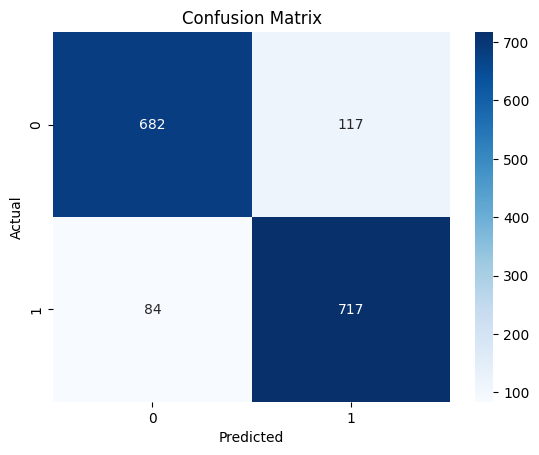

In [ ]:
# Matrice de confusion

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show

In [ ]:
# Bonus (+1) : afficher les 20 termes les plus importants (poids) pour la classe positive et négative.

feature_names = np.array(tfidf.get_feature_names_out())
coef = lr.coef_[0]

top_pos = np.argsort(coef)[-20:][::-1]
top_neg = np.argsort(coef)[:20]

print("Top 20 termes positifs :\n")
for i in top_pos :
  print(f"- {feature_names[i]} : {coef[i]:.4f}")

print("\n---------------------------------------------")

print("\nTop 20 termes negatifs:\n")
for i in top_neg :
  print(f"- {feature_names[i]} : {coef[i]:.4f}")

Top 20 termes positifs :

- great : 4.1155
- and : 2.9774
- excellent : 2.7969
- the best : 2.6219
- love : 2.4737
- best : 2.3864
- perfect : 2.3780
- wonderful : 2.2308
- very : 2.1995
- amazing : 2.1776
- well : 2.1567
- brilliant : 1.9427
- loved : 1.8628
- true : 1.8196
- world : 1.7880
- always : 1.7793
- highly : 1.7770
- you : 1.7377
- favorite : 1.7331
- also : 1.6891

---------------------------------------------

Top 20 termes negatifs:

- bad : -5.3730
- worst : -4.3061
- no : -3.3648
- the worst : -3.3492
- awful : -3.1228
- terrible : -3.0130
- poor : -2.7824
- waste : -2.7785
- script : -2.5041
- boring : -2.4530
- nothing : -2.4403
- minutes : -2.4372
- or : -2.3625
- only : -2.3449
- stupid : -2.3318
- just : -2.1417
- worse : -2.0643
- dull : -2.0148
- even : -1.9876
- money : -1.9170


## 5) Analyse d’erreurs (obligatoire)

✅ **À faire :**
1. Afficher au moins **10 exemples** où le modèle se trompe : texte, vrai label, prédiction, probabilité.
2. Analyser : quelles erreurs reviennent ? (sarcasme, négations, vocabulaire, longueur…)
3. Proposer **2 améliorations**.


In [ ]:
# TODO: afficher des erreurs

y_prob = lr.predict_proba(X_test_tfidf)[:,1]

results = pd.DataFrame({
    'text' : X_test,
    'true_label' : y_test,
    'pred_label' : y_pred,
    'prob_positive' : y_prob
})

errors = results[results['true_label'] != results['pred_label']]

print(f"Nombre total d'erreurs : {len(errors)}")


Nombre total d'erreurs : 201


In [ ]:
# Afficher 10 exemples d'erreurs

errors_sample = errors.sample(10, random_state=RANDOM_STATE)
errors_sample

,text,true_label,pred_label,prob_positive
5637,i believe they were telling the truth the whol...,1,0,0.397215
2087,this movie is told through the eyes of a young...,0,1,0.628408
833,and michael are a married couple that are chea...,0,1,0.549322
7023,this is a pretty good documentary i m not a i ...,1,0,0.348513
821,we all know a movie never does complete justic...,0,1,0.533718
4387,im a huge m fan that s why i ended up watching...,1,0,0.255707
2479,slow and riddled with inaccuracy over looking ...,0,1,0.663716
1974,what starts out as a very predictable and some...,1,0,0.474980
7618,is there anything else on earth to be more ent...,0,1,0.541952
7401,witchery or witchcraft as it s commonly known ...,1,0,0.291799


## 6) Modèle Deep Learning (Embedding + réseau simple)

Vous devez entraîner un modèle Keras simple :
- Tokenizer
- Padding
- Embedding
- GlobalAveragePooling1D (ou LSTM/GRU si vous voulez)
- Dense + Sigmoid

✅ **À faire :**
1. Construire le pipeline.
2. Entraîner sur train et val.
3. Évaluer sur test.
4. Comparer (en 5 lignes) avec le modèle TF-IDF.


In [ ]:
# TODO: Keras deep learning
try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras import layers, Sequential

    # Indices

    # 1) split
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
    )

    # 2) tokenizer
    MAX_VOCAB = 20000
    tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train_final)

    # Convertir en sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train_final)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # 3) pad
    MAX_LEN = 200
    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
    X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

    # 4) model
    EMBED_DIM = 50
    model = Sequential([
        layers.Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=MAX_LEN),
        layers.GlobalAveragePooling1D(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    # 5) fit
    history = model.fit(
        X_train_pad, y_train_final,
        validation_data = (X_val_pad, y_val),
        epochs = 10,
        batch_size = 32,
        verbose = 1
    )

    # 6) eval

    test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
    print(f"Accuracy sur test set : {test_acc:.4f}")

except Exception as e:
    print('⚠️ TensorFlow indisponible:', repr(e))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5485 - loss: 0.6883 - val_accuracy: 0.6836 - val_loss: 0.6620
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7298 - loss: 0.6401 - val_accuracy: 0.7422 - val_loss: 0.5969
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7901 - loss: 0.5537 - val_accuracy: 0.7922 - val_loss: 0.5291
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8381 - loss: 0.4606 - val_accuracy: 0.7961 - val_loss: 0.4758
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8658 - loss: 0.3989 - val_accuracy: 0.8297 - val_loss: 0.4380
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8882 - loss: 0.3446 - val_accuracy: 0.8203 - val_loss: 0.4182
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9049 - loss: 0.2959 - val_accuracy: 0.8281 - val_loss: 0.4002
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9271 - loss: 0.2621 - val_accu

## 7) Question finale (obligatoire) — Déploiement

✅ **À faire (réponse en Markdown) :**
Proposer une architecture simple pour déployer ce classifieur en production (API + monitoring).  
Donner :
- choix techno (ex : FastAPI)
- étapes (prétraitement, modèle, stockage)
- métriques à monitorer
- gestion de dérive (data drift)


**Votre réponse ici :**


# Déploiement d'un classifieur de sentiment NLP

## 1. Choix technologique

- **API** : FastAPI (léger, rapide, Python)
- **Serveur** : Uvicorn pour exécuter FastAPI
- **Stockage modèle** : fichier .h5 ou pickle pour modèle Deep Learning / TF-IDF
- **Base de données** : PostgreSQL ou MongoDB pour stocker les requêtes et résultats

## 2. Architecture et étapes

### a) Prétraitement des textes

- **Nettoyage** : minuscules, suppression ponctuation/chiffres, suppression tokens spéciaux
- **Tokenizer + Padding** (pour Deep Learning) ou TF-IDF vectorizer (pour modèle classique)
- Même pipeline que pour l'entraînement → garantir cohérence

### b) Chargement du modèle

- Charger le modèle Deep Learning (.h5) ou TF-IDF + LogisticRegression (pickle) en mémoire
- Vérifier que le modèle est prêt avant de servir les requêtes

### c) API Endpoint `/predict`

- Reçoit un texte (POST)
- Applique prétraitement + tokenization / TF-IDF
- Fait la prédiction
- Retourne la probabilité et la classe (positive/negative)

### d) Stockage et logging

- Stocker chaque requête et sa prédiction dans une DB ou fichier log
- Utile pour le monitoring et la dérive des données

## 3. Métriques à monitorer

- **Performance du modèle** : accuracy, F1-score sur un petit batch de contrôle (si étiquettes disponibles)
- **Taux d'erreur** / incohérences
- **Distribution des classes** des requêtes entrantes (pour détecter un biais ou dérive)
- **Temps de réponse API** (latence)

## 4. Gestion de la dérive (Data Drift)

- Comparer la distribution des nouveaux textes avec celle des données d'entraînement
- **Exemples** : longueur moyenne des textes, fréquence des mots, proportion positif/négatif
- Détecter si le modèle devient moins précis → déclencher réentraînement périodique
- Automatiser le retraining sur nouvelles données étiquetées (ex: feedback utilisateurs)

## 🔹 Schéma logique simple

```
Texte utilisateur
       │
       ▼
Prétraitement (clean + tokenizer/pad ou TF-IDF)
       │
       ▼
Modèle NLP (Deep Learning ou TF-IDF+LR)
       │
       ▼
Probabilité / Classe
       │
       ▼
Retour API + Logging
```